In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

# Load evaluation results

In [4]:
DATASET_NAMES = ["census", "wine", "credit"]
EVAL_MODELS = dict([(dn, pd.read_csv("../out/eval/{}.csv".format(dn), sep=",")) for dn in DATASET_NAMES])
EVAL_METRICS = ["Accuracy", "F1 Macro", "ROC AUC"]

DATASET_CLEAN_NAMES = {"census": "census", "wine":"wine", "credit": "credit"}

STD_MODELS = ["GBDT", "Random Forest"]
ROBUST_MODELS = ["Adv Boosting", "Robust Trees", "RF-Treant"]
ALL_MODELS = STD_MODELS + ROBUST_MODELS

# Add <code>Accuracy</code> column

In [5]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Accuracy'] = 1 - eval_df['Binary Err Rate']
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:4] + [colnames[-1]] + colnames[4:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Normalize <code>Budget</code> values

In [6]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Training Budget Norm'] = round(eval_df['Training Budget']/eval_df['Training Budget'].max(), 2)
    eval_df['Test Budget Norm'] = round(eval_df['Test Budget']/eval_df['Test Budget'].max(), 2)
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:2] + [colnames[-2]] + [colnames[2]] + [colnames[-1]] + colnames[3:-2]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Computing performance deltas

In [7]:
def delta_performance_dataset(eval_df, metrics):
    
    data = eval_df[(eval_df["Model"].isin(ROBUST_MODELS)) &
                   (eval_df["Training Budget"] == eval_df["Test Budget"]) &
                   (eval_df["Training Budget"] > 0)][["Model", "Training Budget", "Accuracy", "F1 Macro", "ROC AUC"]]
    
    all_data = []
    
    for budget in data["Training Budget"].unique():
        print("Considering budget B = {}".format(budget))
        data_b = data[data['Training Budget'] == budget]
        for metric in metrics:
            print("Evaluation metric = {}".format(metric))
            ab_metric = np.round(data_b[(data_b["Model"] == "Adv Boosting")][metric].iloc[0], 3)
            data_b["Delta {}".format(metric)] = np.round(((np.round(data_b[metric], 3) - ab_metric) * 100) / ab_metric, 1)
        all_data.append(data_b)

    return pd.concat(all_data)

In [8]:
def delta_performance(metrics):
    
    delta_performance_dfs = {}
    
    for dataset in EVAL_MODELS:
        print("***** Examining dataset `{}` *****".format(dataset))
        delta_performance_dfs[dataset] = delta_performance_dataset(EVAL_MODELS[dataset], metrics)
    
    return delta_performance_dfs

In [9]:
delta_performance_dfs = delta_performance(EVAL_METRICS)

***** Examining dataset `census` *****
Considering budget B = 30
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 60
Evaluation metric = Accuracy


/home/lucchese/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 90
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 120
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
***** Examining dataset `wine` *****
Considering budget B = 20
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 40
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 60
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 80
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 100
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
Considering budget B = 120
Evaluation metric = Accuracy
Evaluation metric = F1 Macro
Evaluation metric = ROC AUC
***** E

In [10]:
delta_performance_dfs['credit']

,Model,Training Budget,Accuracy,F1 Macro,ROC AUC,Delta Accuracy,Delta F1 Macro,Delta ROC AUC
16,Adv Boosting,10,0.811000,0.643610,0.749069,0.0,0.0,0.0
20,Robust Trees,10,0.798667,0.610206,0.747960,-1.5,-5.3,-0.1
24,RF-Treant,10,0.816167,0.655868,0.765290,0.6,1.9,2.1
31,Adv Boosting,30,0.785667,0.543987,0.661307,0.0,0.0,0.0
35,Robust Trees,30,0.763000,0.457044,0.655108,-2.9,-16.0,-0.9
39,RF-Treant,30,0.809500,0.617491,0.744533,3.1,13.4,12.7
46,Adv Boosting,40,0.784333,0.554405,0.660017,0.0,0.0,0.0
50,Robust Trees,40,0.759167,0.438245,0.632293,-3.2,-20.9,-4.2
54,RF-Treant,40,0.808333,0.617503,0.744474,3.1,11.6,12.7
61,Adv Boosting,60,0.777000,0.532760,0.621741,0.0,0.0,0.0


# Plotting Security Curves

In [11]:
def plot_data(data, ax, x, metric, y_lims=None, show_y_label=True):
    
    #palette = ["#f37736", "#3385c6", "#ee2e31", "#ffc425", "#009688"]
    palette = ["#ee2e31", "#ffc425", "#009688"]
    
    if x == "Test Budget Norm":
        x_label = "Test Attacker Budget"
    
    if x == "Training Budget Norm":
        x_label = "Training Attacker Budget"
        #_ = ax.axhline(y=data[data["Model"] == "Random Forest"][metric].values[0], ls="-", lw=.75, color="#3385c6")
        #_ = ax.axhline(y=data[data["Model"] == "GBDT"][metric].values[0], ls="--", lw=.75, color="#f37736")
    
    _ = sns.lineplot(x=x, 
                     y= metric, 
                     hue="Model",
                     #markers=["o", "X", "s", "P", "D"],
                     markers=["s", "P", "D"],
                     style="Model",
                     #style_order=["Random Forest", "GBDT", "RF-Treant", "Adv Boosting", "Robust Trees"],
                     style_order=["RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16, labelleft=show_y_label)
    _ = ax.set_xlabel(x_label, fontsize=18, labelpad=12)
    
    if show_y_label: 
        _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)
    else: 
        _ = ax.set_ylabel('')
#        _ = ax.set_ylabel('')
    
    if y_lims:
        _ = ax.set_ylim(y_lims)

In [12]:
def plot_all_dataset(df, metrics, models, axes, x, max_budget, y_lims=None, show_y_label=True):
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for model in models:
            # get the slice of the dataframe corresponding to the current model (e.g., "GBDT")
            model_df = df.loc[df["Model"] == model]
            
            data.append(model_df[model_df[max_budget] == model_df[max_budget].max()])
        if y_lims:    
            plot_data(pd.concat(data, axis=0), axes[m_i], x, m, y_lims[m_i], show_y_label)
        else:
            plot_data(pd.concat(data, axis=0), axes[m_i], x, m)
    
    plt.tight_layout(pad=1)

In [13]:
def plot_all(eval_models, eval_metrics, models, dataset_names, x, max_budget, y_lims=None):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=y_lims==None, 
                             figsize=(18, 9))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        if y_lims:
            plot_all_dataset(eval_models[dataset], eval_metrics, models, axes[:, j], x, max_budget, y_lims[j], j==0)
        else:
            plot_all_dataset(eval_models[dataset], eval_metrics, models, axes[:, j], x, max_budget)
            
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New", pad=12)
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for i, ax in enumerate(flat_axes):
        ax.get_legend().remove()
        
    fig.legend(handles=[handles[2], handles[0], handles[1]], #[handles[-1], handles[2], handles[3], handles[1], handles[0]],
               labels=[labels[2], labels[0], labels[1]], #[labels[-1], labels[2], labels[3], labels[1], labels[0]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=3,
               markerscale=2.
              )

# 1. Plot max _training_ budget vs. many _test_ budgets

Fixing max _training_ budget, plot GBDT, RF, AB, RT, and RF-Treant when attacked with different _test_ budgets

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...


findfont: Font family ['Courier New'] not found. Falling back to DejaVu Sans.


Generating evaluation subplot for dataset `credit`...


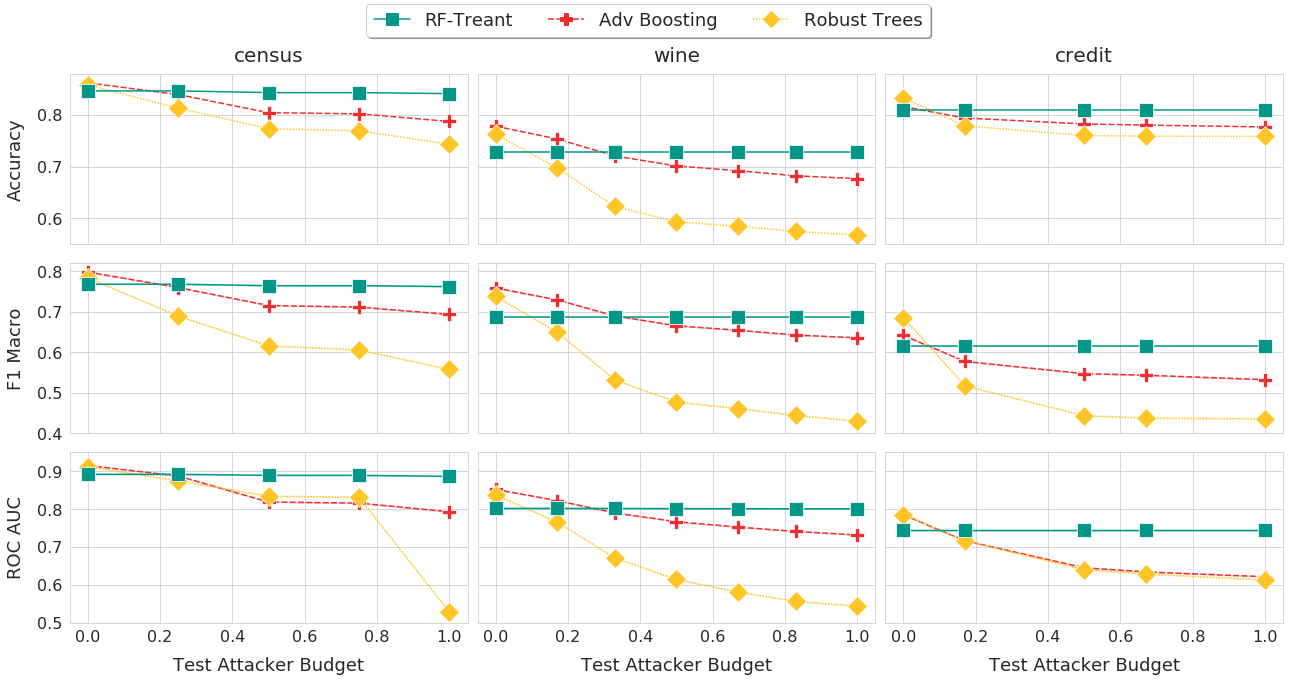

In [14]:
y_lims = [ [(.55,.88),(.4,.82),(.5,.95) ] ,
           [(.55,.88),(.4,.82),(.5,.95) ] ,
           [(.55,.88),(.4,.82),(.5,.95) ] ]
#y_lims = None

plot_all(EVAL_MODELS, 
         EVAL_METRICS, 
         ROBUST_MODELS, #ALL_MODELS
         DATASET_CLEAN_NAMES, 
         x="Test Budget Norm", 
         max_budget="Training Budget",
         y_lims=y_lims
        )

# 2. Plot max _test_ budget vs. many _training_ budgets

Fixing max _test_ budget, plot GBDT, RF, AB, RT, and RF-Treant when attacked with different _test_ budgets

In [ ]:
y_lims = [ [(0.55,.9),(0.45,.8),(.2,.92) ] ,
           [(.5,.75),(.3,.75),(.25,.85) ] ,
           [(.7,.82),(.4,.65),(.5,.8) ] ]

y_lims = None

In [ ]:
plot_all(EVAL_MODELS, 
         EVAL_METRICS, 
         ROBUST_MODELS, #ALL_MODELS 
         DATASET_CLEAN_NAMES, 
         x="Training Budget Norm", 
         max_budget="Test Budget",
         y_lims=y_lims
        )

# Plot Adversarial Boosting vs. Robust Trees vs. RF-Treant vs. GBDT vs. RF

In [ ]:
def plot_atk(data, ax, metric):
    
    palette = ["#f37736", "#3385c6", "#ee2e31", "#ffc425", "#009688"]
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=["o", "X", "s", "P", "D"],
                     style="Model",
                     style_order=["Random Forest", "GBDT", "RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [ ]:
def plot_atk_dataset(df, metrics, models, axes):
    
    test_budgets = df["Test Budget"].unique()
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for b_i, b in enumerate(test_budgets):
            
            data.append(df.loc[(df["Model"].isin(models)) & 
                               (df["Training Budget"] == b) & 
                               (df["Test Budget"] == b) |
                               (df["Model"] == "GBDT") |
                               (df["Model"] == "Random Forest") |
                               (df["Test Budget"] == 0)
                              ]) # & (df["Test Budget"] > 0) & (df["Test Budget"] == b)])
            
        plot_atk(pd.concat(data, axis=0), axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [ ]:
def plot_all_atk_datasets(eval_models, eval_metrics, robust_models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 12))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_atk_dataset(eval_models[dataset], eval_metrics, robust_models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for i, ax in enumerate(flat_axes):
        ax.get_legend().remove()
        
    fig.legend(handles=[handles[-1], handles[2], handles[3], handles[1], handles[0]],
               labels=[labels[-1], labels[2], labels[3], labels[1], labels[0]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=5,
               markerscale=2.
              )

In [ ]:
plot_all_atk_datasets(EVAL_MODELS, EVAL_METRICS, ALL_MODELS, DATASET_CLEAN_NAMES)

# Multiple Plots

# 1. Plot Standard GBDT vs. RF

In [ ]:
def plot_std(data, ax, metric, y_lims=None, show_y_label=True):
    
    palette = ["#f37736", "#3385c6"] 
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     style_order=["Random Forest", "GBDT"],
                     data=data,
                     markersize=14, #18,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)#22)
    _ = ax.set_xlabel("Test Attacker Budget", 
                      fontsize=18, #26, 
                      labelpad=12)
    
    if show_y_label: 
        _ = ax.set_ylabel(metric, 
                          fontsize=18, #26, 
                          labelpad=12)
    else: 
        _ = ax.set_ylabel('')
    
    if y_lims:
        _ = ax.set_ylim(y_lims)

In [ ]:
def plot_std_dataset(df, metrics, std_models, axes, y_lims=None, show_y_label=True):
    
    for m_i, m in enumerate(metrics):
        if y_lims:
            plot_std(df[(df['Model']=='GBDT') | (df['Model']=='Random Forest')], axes[m_i], m, y_lims[m_i], show_y_label)
        else:
            plot_std(df[(df['Model']=='GBDT') | (df['Model']=='Random Forest')], axes[m_i], m)
    
    plt.tight_layout(pad=1)
        

In [ ]:
def plot_all_std_datasets(eval_models, eval_metrics, std_models, dataset_names, y_lims=None):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=y_lims==None, 
                             figsize=(18, 8))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        if y_lims:
            plot_std_dataset(eval_models[dataset], eval_metrics, std_models, axes[:, j], y_lims[j], j==0)
        else:
            plot_std_dataset(eval_models[dataset], eval_metrics, std_models, axes[:, j])
            
        _ = axes[0, j].set_title(dataset_names[dataset], 
                                 fontsize=20, #28, 
                                 fontname='Courier New', 
                                 pad=12)
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    for ax in flat_axes:
        ax.get_legend().remove()  
    
    fig.legend(handles=handles[::-1], 
               labels=labels[::-1],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), #(0.5, 1.15), 
               fontsize=18, #28,
               fancybox=True, 
               shadow=True,
               ncol=2,
               markerscale=2.
              )

In [ ]:
y_lims = [ [(.45,.9),(.2,.85),(.2,1) ] ,
           [(.45,.9),(.2,.85),(.2,1) ] ,
           [(.45,.9),(.2,.85),(.2,1) ] ]

# y_lims = None

plot_all_std_datasets(EVAL_MODELS, EVAL_METRICS, STD_MODELS, DATASET_CLEAN_NAMES, y_lims=y_lims)

# 2. Plot Adversarial Boosting vs. Robust Trees vs. RF-Treant

In [ ]:
def plot_atk(data, ax, metric):
    
    palette = ["#ee2e31", "#ffc425", "#009688"] #ee4035 "#4281a4" "#edc951"
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=["s", "P", "D"],
                     style="Model",
                     style_order=["RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [ ]:
def plot_atk_dataset(df, metrics, models, axes):
    
    test_budgets = df["Test Budget"].unique() # [1:]
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for b_i, b in enumerate(test_budgets):
            # mask = []
            # for rm in robust_models:
                # mask.append("{} [train budget={}]".format(rm, b))
            # data.append(df.loc[(df["Model"].isin(mask)) & (df["Budget"] == b)].replace(regex=r' \[train.*\]', value=''))
            data.append(df.loc[(df["Model"].isin(models)) & (df["Training Budget"] == b) & (df["Test Budget"] > 0)]) # & (df["Test Budget"] == b)])
            
        plot_atk(pd.concat(data, axis=0), axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [ ]:
def plot_all_atk_datasets(eval_models, eval_metrics, robust_models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 12))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_atk_dataset(eval_models[dataset], eval_metrics, robust_models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for i, ax in enumerate(flat_axes):
        ax.get_legend().remove()
#         I was trying to adjust x_lim for the `census` dataset but set_xlim/set_ylim has a "global" effect
#         since we are using sharex=True and sharey=True
#         print(ax.get_xlim())
#         if i % 3 == 0:
#             ax.set_xlim(0.2, 1.05)
#         print(ax.get_xlim())
        
    fig.legend(handles=[handles[2], handles[0], handles[1]], 
               labels=[labels[2], labels[0], labels[1]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=3,
               markerscale=2.
              )

In [ ]:
plot_all_atk_datasets(EVAL_MODELS, EVAL_METRICS, ROBUST_MODELS, DATASET_CLEAN_NAMES)

# 3. Efficiency-Robustness Tradeoff

In [ ]:
def plot_tradeoff(data, ax, metric):
    
    palette = ["#f37736", "#3385c6", "#ee2e31", "#ffc425", "#009688"]
    #palette = ["#f37736", "#3385c6", "#009688"] 
    
    _ = sns.lineplot(x="Training Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     #style_order=["Random Forest", "GBDT", "RF-Treant"],
                     style_order=["Random Forest", "GBDT", "RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Train Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)
    # draw two horizontal lines for standard models (GBDT and RF)
    _ = ax.axhline(y=data[data["Model"] == "Random Forest"][metric].values[0], ls="-", lw=.5, color="#3385c6")
    _ = ax.axhline(y=data[data["Model"] == "GBDT"][metric].values[0], ls="--", lw=.5, color="#f37736")
    _ = ax.set_ylim(0.6, 0.95)

In [ ]:
def plot_tradeoff_dataset(df, metrics, models, axes):
    
    for m_i, m in enumerate(metrics):   
        plot_tradeoff(df[(df["Model"].isin(models)) & (df['Test Budget']==0)], axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [ ]:
def plot_all_tradeoff_datasets(eval_models, eval_metrics, models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 10))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_tradeoff_dataset(eval_models[dataset], eval_metrics, models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
        
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for ax in flat_axes:
        ax.get_legend().remove()

    fig.legend(handles=handles,#[handles[1], handles[0], handles[-1], handles[2], handles[3]], #handles,
               labels=labels,#[labels[1], labels[0], labels[-1], labels[2], labels[3]], # labels,
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=5,
               markerscale=2.
              )

In [ ]:
MODELS = STD_MODELS + ["RF-Treant"]
MODELS = ALL_MODELS

plot_all_tradeoff_datasets(EVAL_MODELS, EVAL_METRICS, MODELS, DATASET_CLEAN_NAMES)

# OLD VERSION!!! Plot GBDT vs. RF under attack

In [ ]:
# #d11141 #00b159 #00aedb #f37735 #ffc425

def plot_standard(eval_df, dataset_name, eval_metrics, ax):
    sns.set_style("whitegrid")
    atk_budgets = eval_df['Budget Norm'].unique()
    #fig, ax = plt.subplots(1, 1, figsize=(6,6))
    palette = ['#d11141', '#00b159'] #, '#00aedb', '#f37735', '#ffc425', '#8874a3']
    palette = ['#00aedb', '#d11141']
    ls = ['-', '--']
    markers=['^', 's','o']
    for i, metric in enumerate(eval_metrics):
        _ = sns.lineplot(x="Budget Norm", 
                        y= metric, 
                        hue="Model",
                        markers=[markers[i], markers[i]],
                        style="Model",
                        style_order=["GBDT", "Random Forest"],
                        palette=palette, #[i*2:i*2+2],
                        data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')],
                        markersize=12,
                        ax=ax)
        #_ = ax.set_xlabel("attacker's budget", fontsize=18, labelpad=12)
        #_ = ax.set_ylabel("metric", fontsize=18, labelpad=12)
        _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        _ = ax.set_title(dataset_name, fontsize=22)
        legend_elements = [Line2D([0], [0], color='#00aedb', lw=2),
                           Line2D([0], [0], color='#d11141', lw=2, ls="--"),
                           Line2D([0], [0], color='black', lw=1, marker="^", markersize=8), #, mew=3),
                           Line2D([0], [0], color='black', lw=1, marker="s", markersize=8),
                           Line2D([0], [0], color='black', lw=1, marker="o", markersize=8)
                          ]
        
        leg = ax.legend(title='Models', 
                      loc='best', 
                      handles=legend_elements, 
                      labels=['GBDT', 'Random Forest', 'Accuracy', 'F1 Macro', 'ROC AUC'],
                      borderpad=1,
                      fontsize=16)
        leg.get_title().set_fontsize(16)

In [ ]:
def plot_all_standard(eval_dict, eval_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,8))
    i = 0
    for dataset_name in eval_dict:
        print("Plotting GBDT vs. RF under attack for dataset `{}`...".format(dataset_name))
        plot_standard(eval_dict[dataset_name], dataset_name, eval_metrics, axes[i])
        axes[i].set_xlabel("attacker's budget", fontsize=20, labelpad=12)          
        if i == 0:
            axes[i].set_ylabel("metric", fontsize=20, labelpad=12)
        i += 1
    plt.tight_layout(pad=2.5)
    

In [ ]:
plot_all_standard(EVAL_MODELS, EVAL_METRICS)